In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import noisereduce as nr
import numpy as np
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import keras
from keras import layers
from keras.applications import EfficientNetB1
from PIL import Image
from sklearn.calibration import LabelEncoder
import hashlib

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ruta a la carpeta con los archivos de audio
folder_path = "./Dataset-Birds/training/"

# Obtener la lista de archivos en la carpeta
file_list = os.listdir(folder_path)
# Filtrar la lista para obtener solo los archivos de audio
audio_files = [file for file in file_list if file.endswith('.wav')]

# Crear una lista de diccionarios con etiqueta y ruta
data = []
for audio_file in audio_files:
    label, _ = audio_file.split('.', 1)
    data.append({'label': label, 'path': os.path.join(folder_path, audio_file)})

# Crear el DataFrame
df = pd.DataFrame(data)

# Mostrar el DataFrame
# print(df)


class_scientificnames = df['label'].unique()
class_commonnames = [
    "Amazona Frentirroja",
    "Picamaderos de Guayaquil",
    "Tinamú Cejudo",
    "Chachalaca Cabecirrufa",
    "Busardo Dorsigrís",
    "Aratinga de Guayaquil",
]
print(class_scientificnames)
print(df['label'].value_counts())


['Amazona Autamnails' 'Campephilus gayaquilensis'
 'Crypturellus tansfasciatus' 'Ortalis erythroptera'
 'Pseudastur occidentalis' 'Psittacara erythrogenys']
label
Amazona Autamnails            682
Psittacara erythrogenys       522
Ortalis erythroptera          402
Campephilus gayaquilensis     187
Crypturellus tansfasciatus    165
Pseudastur occidentalis        89
Name: count, dtype: int64


In [3]:
def createSegmentationVectorPredict(segment_dur_secs, signal, sr, split):
    segment_length = sr * segment_dur_secs
    for s in range(0, len(signal), segment_length):
        t = signal[s : s + segment_length]
        split.append(t)
        if len(t) < segment_length and len(t) > segment_length:
            split.pop()
            miss = segment_length - len(t)
            missarray = np.zeros(miss)
            t = np.array(list(t) + list(missarray))
            split.append(t)
        elif len(t) < segment_length:
            split.pop()
    return split

In [16]:

def createSpectogramImage(signal, sr, label, save_dir="Dataset-Images"):
    # Nuevos parámetros para el espectrograma con una frecuencia de muestreo de 48 kHz
    N_FFT = 2048  # Ajustado para 48 kHz
    HOP_SIZE = 1024
    N_MELS = 128
    FMIN = 0

    # Crear el espectrograma
    spectrogram = librosa.feature.mfcc(
        y=signal,
        sr=sr,
        n_mfcc=40,
        n_fft=N_FFT,
        hop_length=HOP_SIZE,
        n_mels=N_MELS,
        htk=True,
        fmin=FMIN,
        fmax=sr / 2,
    )

    # Normalizar el espectrograma
    mean = np.mean(spectrogram)
    std = np.std(spectrogram)
    normalized_spectrogram = (spectrogram - mean) / std

    # Configurar la ruta de guardado
    filename = f"{label}_{hashlib.sha1(signal.tobytes()).hexdigest()[:8]}_{len(os.listdir(save_dir))}.png"
    save_path = os.path.join(save_dir, filename)

    # Visualizar el espectrograma normalizado sin valores de frecuencia
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        librosa.power_to_db(normalized_spectrogram**2, ref=np.max), fmin=FMIN, y_axis="off"
    )

    # Eliminar la barra de colores
    plt.colorbar(format="%+2.0f dB").remove()

    # Guardar la figura en el archivo de imagen
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    return save_path


In [14]:
def createSpectogramImageLog(signal, sr, label, save_dir="Dataset-Images-Log-test"):
    n_fft = 2**11  # Nro. de muestras para cada ventana donde se va a realizar la stft
    hop_length = int(n_fft/4)  # Cuántas muestras se va a mover la ventana en cada desplazamiento (hop: salto)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann')
    spectrogram_magnitude = np.abs(stft)

    # Configurar la ruta de guardado
    filename = f"{label}_{hashlib.sha1(signal.tobytes()).hexdigest()[:8]}_{len(os.listdir(save_dir))}.png"
    save_path = os.path.join(save_dir, filename)

    # Visualizar el espectrograma normalizado sin valores de frecuencia
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(spectrogram_magnitude, y_axis='log', x_axis='time', sr=sr, hop_length=512)

    # Eliminar etiquetas de ejes x e y
    plt.axis('off')

    # Eliminar la barra de colores
    plt.colorbar(format="%+2.0f dB").remove()

    # Guardar la figura en el archivo de imagen
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    return save_path

In [18]:
def createSpectogramImageMel(signal, sr, label, save_dir="Dataset-Images-Mel"):
    n_fft = 2**11  # Nro. de muestras para cada ventana donde se va a realizar la stft
    hop_length = int(n_fft/4)  # Cuántas muestras se va a mover la ventana en cada desplazamiento (hop: salto)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann')
    spectrogram_magnitude = np.abs(stft)
    
    # Configurar la ruta de guardado
    filename = f"{label}_{hashlib.sha1(signal.tobytes()).hexdigest()[:8]}_{len(os.listdir(save_dir))}.png"
    save_path = os.path.join(save_dir, filename)

    # Visualizar el espectrograma normalizado sin valores de frecuencia
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.patch.set_facecolor('white')
    spectrogram_dB = librosa.amplitude_to_db(spectrogram_magnitude, ref=np.max)
    librosa.display.specshow(spectrogram_dB, y_axis='mel', fmin=0, fmax=sr/2, x_axis='time', sr=sr, hop_length=hop_length)

    ax.set_title('Espectograma: Frecuencia en escala Mel. Amplitud: Decibeles.')
    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Frecuencia [Hz]')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

    # Guardar la figura en el archivo de imagen
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    return save_path

In [4]:
random_data = df.sample()
random_path = random_data['path'].values[0]  # Acceder al valor de la primera fila
random_label = random_data['label'].values[0]  # Acceder al valor de la primera fila
# Mostrar la ruta aleatoria
print("Ruta aleatoria:", random_path)
print("Label aleatorio:", random_label)
# print(random_data)

Ruta aleatoria: ./Dataset-Birds/training/Pseudastur occidentalis.XC297196 - Busardo dorsigris - Pseudastur occidentalis.mp3.wav.46p2n8qo.ingestion-bd4fc78ff-qj69s.s2.wav
Label aleatorio: Pseudastur occidentalis


In [5]:
import IPython

# Ejemplo de uso
signal, sr = librosa.load(random_path,sr=None)  # sr = sampling rate
IPython.display.Audio(signal, rate=sr)

In [6]:
import IPython

# Ejemplo de uso
signal, sr = librosa.load(random_path,sr=None)  # sr = sampling rate
signal = nr.reduce_noise(y=signal, y_noise=signal, prop_decrease=1, sr=sr)
IPython.display.Audio(signal, rate=sr)

In [7]:
def createSpectogramImageLog(signal, sr, label, save_dir="Dataset-Images-Log-test"):
    n_fft = 2**12  # Aumento de la resolución en frecuencia
    hop_length = int(n_fft/4)  # Ajuste del desplazamiento de la ventana
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann')
    spectrogram_magnitude = np.abs(stft)

    # Normalizar el espectrograma
    spectrogram_magnitude = librosa.amplitude_to_db(spectrogram_magnitude, ref=np.max)

    # Configurar la ruta de guardado
    filename = f"{label}_{hashlib.sha1(signal.tobytes()).hexdigest()[:8]}_{len(os.listdir(save_dir))}.png"
    save_path = os.path.join(save_dir, filename)

    # Visualizar el espectrograma normalizado sin valores de frecuencia
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_magnitude, y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)

    # Eliminar etiquetas de ejes x e y
    plt.axis('off')

    # Eliminar la barra de colores
    plt.colorbar(format="%+2.0f dB").remove()

    # Guardar la figura en el archivo de imagen
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    return save_path


In [15]:
# Llamada a la función y visualización del espectrograma
# print(createSpectogramImageMel(signal=signal, sr=sr, label=random_label))
print(createSpectogramImageLog(signal=signal, sr=sr, label=random_label))

Dataset-Images-Log-test\Pseudastur occidentalis_2bb3cb96_1.png


In [132]:
data_training = []
for index, row in df.iterrows():
    path = row["path"]
    label = row["label"]
    if label not in ["Amazona Autamnails", "Psittacara erythrogenys", "Ortalis erythroptera"]:
        signal, sr = librosa.load(path,sr=None)  # sr = sampling rate
        signal = nr.reduce_noise(y=signal, y_noise=signal, prop_decrease=1, sr=sr)
        y_roll = np.roll(signal, 7000)
        y_pitch2 = np.roll(signal, 30000)
        y_scaled = 0.6 * signal  # Reducir la amplitud en un 40%

        pitchspectogram2_path = createSpectogramImageLog(signal=y_pitch2, sr=sr, label=label)
        data_training.append([pitchspectogram2_path, label])

        pitchspectogram_path = createSpectogramImageLog(signal=y_roll, sr=sr, label=label)
        scaledspectogram_path = createSpectogramImageLog(signal=y_scaled, sr=sr, label=label)
        spectogram_path = createSpectogramImageLog(signal=signal, sr=sr, label=label)

        # Agregar las rutas de los espectrogramas y las etiquetas al conjunto de datos
        data_training.append([spectogram_path, label])
        data_training.append([pitchspectogram_path, label])
        data_training.append([scaledspectogram_path, label])

    else:
        signal, sr = librosa.load(path,sr=None)  # sr = sampling rate
        signal = nr.reduce_noise(y=signal, y_noise=signal, prop_decrease=1, sr=sr)
        spectogram_path = createSpectogramImageLog(signal=signal, sr=sr, label=label)
        data_training.append([spectogram_path, label])

In [12]:
# Ruta de la carpeta que contiene las imágenes
carpeta_dataset = 'Dataset-Images-Log'

# Inicializar listas para almacenar paths de imágenes y nombres de clases
paths_imagenes = []
nombres_clases = []

# Recorrer los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_dataset):
    # Obtener la ruta completa del archivo
    path_completo = os.path.join(carpeta_dataset, nombre_archivo)
    
    # Verificar si es un archivo y si es una imagen (puedes ajustar esta condición según tus necesidades)
    if os.path.isfile(path_completo) and nombre_archivo.lower().endswith('.png'):
        # Dividir el nombre del archivo para obtener la clase y añadir a las listas
        partes_nombre = os.path.splitext(nombre_archivo)[0].split('_')
        nombre_clase = partes_nombre[0]
        
        paths_imagenes.append(path_completo)
        nombres_clases.append(nombre_clase)

paths = []
for path in paths_imagenes:
    image = Image.open(path)
    # Puedes realizar cualquier preprocesamiento adicional aquí si es necesario
    image = np.array(image)  # Convertir a formato NumPy si estás utilizando TensorFlow
    # Agregar la imagen y la etiqueta a las listas
    paths.append(image)

# Utilizar LabelEncoder para asignar un número único a cada etiqueta
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nombres_clases)

# Convertir a representación categórica
categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(set(nombres_clases)))

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data, train_labels, val_labels = train_test_split(paths, categorical_labels, test_size=0.2, random_state=42)

# Mostrar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data)}")
print(f"Número de muestras de validación: {len(val_data)}")


Número de muestras de entrenamiento: 2696
Número de muestras de validación: 674


In [ ]:
# Supongamos que data_training tiene la estructura [(ruta_1, etiqueta_1), (ruta_2, etiqueta_2), ...]
from PIL import Image

# Obtener solo las etiquetas
from sklearn.calibration import LabelEncoder

labels = [item[1] for item in data_training]
paths = []

for path in [item[0] for item in data_training]:
    image = Image.open(path)
    # Puedes realizar cualquier preprocesamiento adicional aquí si es necesario
    image = np.array(image)  # Convertir a formato NumPy si estás utilizando TensorFlow
    # Agregar la imagen y la etiqueta a las listas
    paths.append(image)


# Utilizar LabelEncoder para asignar un número único a cada etiqueta
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convertir a representación categórica
categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(set(labels)))

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data, train_labels, val_labels = train_test_split(paths, categorical_labels, test_size=0.2, random_state=42)

# Mostrar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data)}")
print(f"Número de muestras de validación: {len(val_data)}")

In [13]:
print(f"Forma de train_data: {np.array(train_data).shape}")
print(f"Forma de val_data: {np.array(val_data).shape}")
print(f"Forma de train_labels: {train_labels.shape}")
print(f"Forma de val_labels: {val_labels.shape}")


Forma de train_data: (2696, 385, 1162, 4)
Forma de val_data: (674, 385, 1162, 4)
Forma de train_labels: (2696, 6)
Forma de val_labels: (674, 6)


In [ ]:
extraced_features_df = pd.DataFrame(data_training, columns=['Feature','Class'])
print(extraced_features_df['Class'].value_counts())

In [15]:

train_audios = np.resize(train_data, (np.array(train_data).shape[0], IMG_SIZE, IMG_SIZE,3))
val_audios = np.resize(val_data, (np.array(val_data).shape[0], IMG_SIZE, IMG_SIZE,3))

In [16]:
print(train_audios.shape)
print(val_audios.shape)

(2696, 224, 224, 3)
(674, 224, 224, 3)


In [17]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB1(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),#from_logits=False
        metrics=["accuracy"],
)
    return model

In [ ]:
model = EfficientNetB1(
    include_top=True,
    weights=None,
    classes=6,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_audios, train_labels, epochs=epochs,validation_data= (val_audios,val_labels))

In [18]:

model = build_model(num_classes=6)
epochs = 25  
batch_size = 32
hist = model.fit(
    train_audios,
    train_labels,
    epochs=epochs,
    # batch_size=batch_size,
    validation_data= (val_audios,val_labels),
    steps_per_epoch=int(np.ceil(len(train_audios) / float(batch_size))),
    validation_steps=int(np.ceil(len(val_audios) / float(batch_size)))
)

Epoch 1/25
85/85 [==============================] - 12s 55ms/step - loss: 2.1401 - accuracy: 0.1784 - val_loss: 1.7650 - val_accuracy: 0.2107
Epoch 2/25
85/85 [==============================] - 3s 41ms/step - loss: 2.0340 - accuracy: 0.1914 - val_loss: 1.7602 - val_accuracy: 0.2092
Epoch 3/25
85/85 [==============================] - 3s 41ms/step - loss: 2.0075 - accuracy: 0.1792 - val_loss: 1.7604 - val_accuracy: 0.2107
Epoch 4/25
85/85 [==============================] - 3s 41ms/step - loss: 1.9850 - accuracy: 0.1810 - val_loss: 1.7650 - val_accuracy: 0.2018
Epoch 5/25
85/85 [==============================] - 3s 41ms/step - loss: 1.9633 - accuracy: 0.1962 - val_loss: 1.7634 - val_accuracy: 0.2062
Epoch 6/25
85/85 [==============================] - 3s 41ms/step - loss: 1.9715 - accuracy: 0.1966 - val_loss: 1.7643 - val_accuracy: 0.2181
Epoch 7/25
85/85 [==============================] - 3s 41ms/step - loss: 1.9421 - accuracy: 0.1858 - val_loss: 1.7685 - val_accuracy: 0.2107
Epoch 8/25
8

KeyboardInterrupt: 

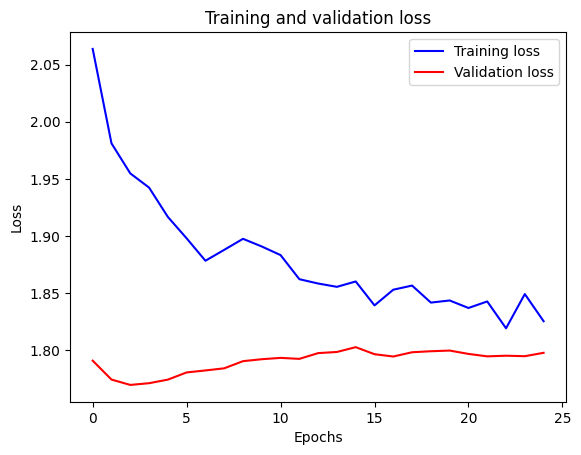

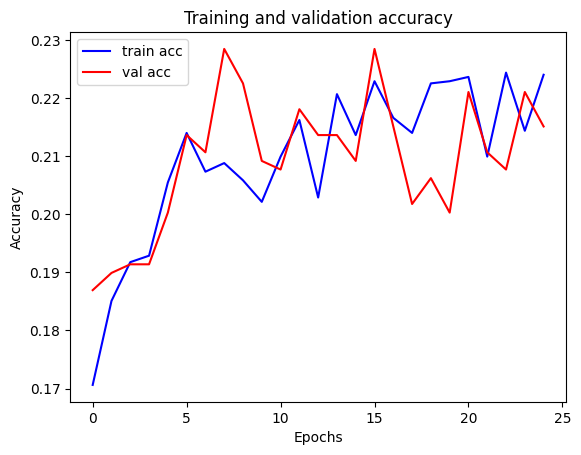

In [275]:
plt.plot(hist.history["loss"], 'b',label="Training loss")
plt.plot(hist.history["val_loss"], 'r', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot the accuracy
plt.plot(hist.history['accuracy'],'b', label='train acc')
plt.plot(hist.history['val_accuracy'],'r', label='val acc')
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [277]:
#Testing
results_train = model.evaluate(train_audios, train_labels)
results_test  = model.evaluate(val_audios, val_labels)

print (f"\n results_train: Loss, Accuracy ==> {results_train}")
print (f" results_test : Loss, Accuracy ==> {results_test}")

22/22 [==============================] - 0s 21ms/step - loss: 1.7979 - accuracy: 0.2151

 results_train: Loss, Accuracy ==> [1.7136770486831665, 0.27410978078842163]
 results_test : Loss, Accuracy ==> [1.7979496717453003, 0.21513353288173676]


22/22 [==============================] - 1s 35ms/step


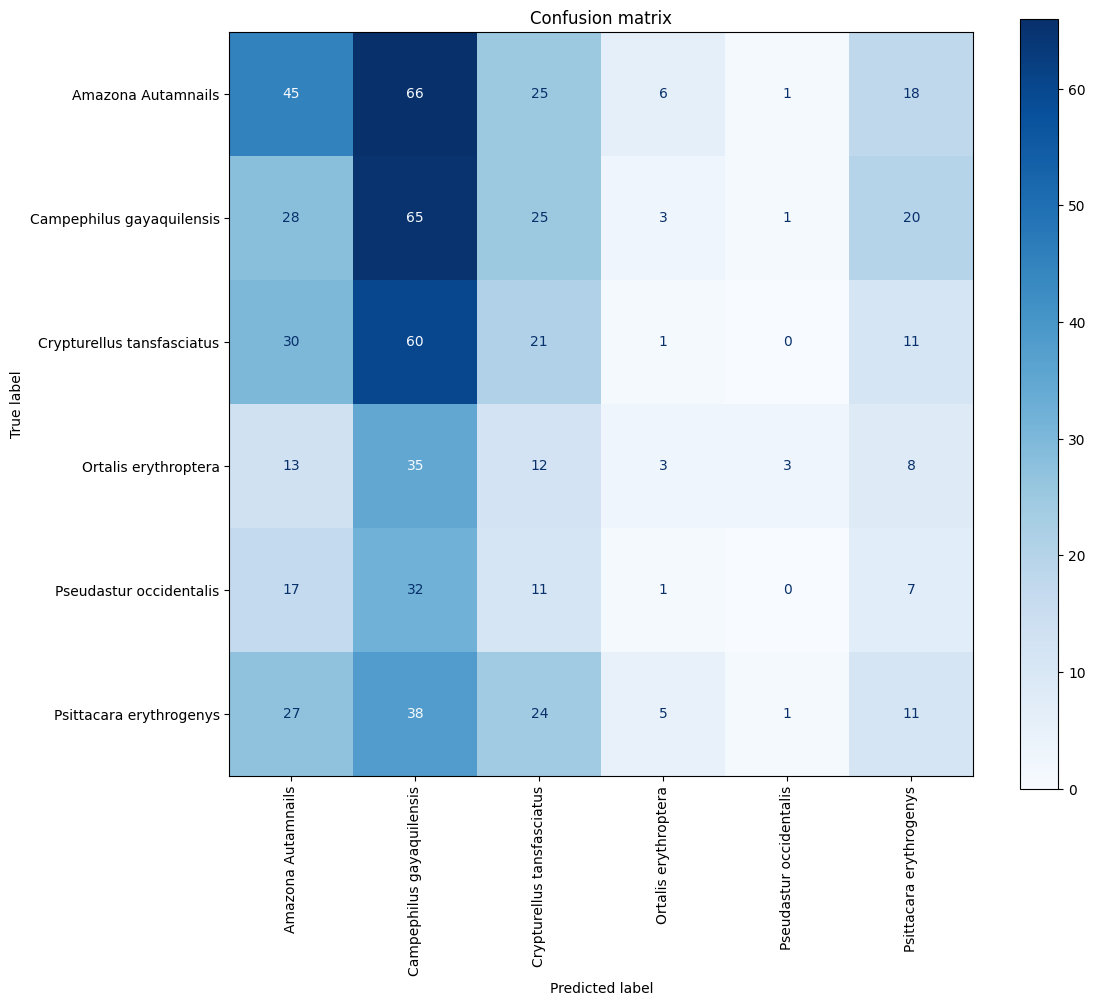

In [281]:

predictions_values=model.predict(val_audios)
predictions=predictions_values.argmax(axis=1)


# Convertir las predicciones a representaciones categóricas
categorical_predictions = tf.keras.utils.to_categorical(predictions, num_classes=len(class_scientificnames))

# Crear la matriz de confusión
cm = confusion_matrix(val_labels.argmax(axis=1), categorical_predictions.argmax(axis=1), normalize=None)

# Crear la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_scientificnames)

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 10))

disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion matrix')
plt.show()

In [205]:

timeserie = 0
predictions = []
for file in os.listdir('./Audio-Environment/'):
    FILEPATH = os.path.join('./Audio-Environment/','Audio de la Plana chachalaca .HD-YoutubeConvert.cc.wav')
    signal, sr = librosa.load(FILEPATH)
    # signal = nr.reduce_noise(y=signal, y_noise=signal, prop_decrease=1, sr = sr)  
    audio_slices = createSegmentationVectorPredict(2,signal,sr,[])
    timeserie = datetime.timedelta(seconds=0)
    for i in range(len(audio_slices)):
        vectorMFFC=createSpectogramImage(signal=audio_slices[i], sr=sr)
        vectoresPredict = [vectorMFFC]
        prediction = np.array(vectoresPredict)
        prediction = test_model.predict(prediction)
        timeserie = timeserie + datetime.timedelta(seconds=2)        
        if(prediction.max() > 0.70):
            predictions.append((class_commonnames[prediction.argmax()],prediction.max(),timeserie))
        else:
            predictions.append(("Not Detected",prediction.max(),timeserie))
    break


1/1 [==============================] - 0s 12ms/step


In [204]:
predictions

[('Not Detected', 0.6895974, datetime.timedelta(seconds=2)),
 ('Chachalaca Cabecirrufa', 0.8834114, datetime.timedelta(seconds=4)),
 ('Not Detected', 0.7733321, datetime.timedelta(seconds=6)),
 ('Not Detected', 0.79807884, datetime.timedelta(seconds=8)),
 ('Not Detected', 0.4094905, datetime.timedelta(seconds=10)),
 ('Not Detected', 0.5188577, datetime.timedelta(seconds=12)),
 ('Chachalaca Cabecirrufa', 0.8671427, datetime.timedelta(seconds=14)),
 ('Chachalaca Cabecirrufa', 0.9974655, datetime.timedelta(seconds=16)),
 ('Chachalaca Cabecirrufa', 0.9994604, datetime.timedelta(seconds=18)),
 ('Not Detected', 0.78223175, datetime.timedelta(seconds=20)),
 ('Not Detected', 0.74107337, datetime.timedelta(seconds=22)),
 ('Chachalaca Cabecirrufa', 0.87706506, datetime.timedelta(seconds=24))]

In [111]:
jsonPredictions = {}
# Función para calcular la votación mayoritaria
def weighted_majority_vote(predictions):
    if len(predictions) == 0:
        return 'Anomaly'
    
    unique_classes, counts = np.unique(predictions, return_counts=True)
    
    # Asignar un peso mayor a las clases que no son "Not Detected"
    class_weights = [2 if cls != 'Not Detected' else 1 for cls in unique_classes]
    weighted_counts = [count * weight for count, weight in zip(counts, class_weights)]
    
    max_count = np.max(weighted_counts)
    
    if np.sum(weighted_counts == max_count) > 1:
        return 'Anomaly'
    
    majority_class = unique_classes[np.argmax(weighted_counts)]
    return majority_class

def time_to_seconds(time_obj):
    total_seconds = int(time_obj.total_seconds())
    return total_seconds

def seconds_to_time(seconds):
    return datetime.time(hour=seconds // 3600, minute=(seconds % 3600) // 60, second=seconds % 60)


# Calcular el número de intervalos y el tamaño del intervalo en función de la duración del audio
audio_duration = time_to_seconds(timeserie)  # Duración del audio en segundos
interval_size = 8  # Tamaño del intervalo en segundos

# Calcular el número de intervalos
num_intervals = int(np.ceil(audio_duration / interval_size))

# Dividir las predicciones en intervalos y aplicar enfoques
for i in range(num_intervals):
    start_time = i * interval_size
    end_time = (i + 1) * interval_size
    interval_predictions = []
    for pred in predictions: 
        pred_time_seconds = time_to_seconds(pred[2])
        if start_time < pred_time_seconds <= end_time:
            interval_predictions.append(pred[0])
            
    # Votación Mayoritaria
    majority_prediction = weighted_majority_vote(interval_predictions)
    if(majority_prediction == 'Not Detected' ): 
        scientificname = 'Not Detected'
    elif(majority_prediction == 'Anomaly'):
        scientificname = 'Anomaly'
    else: 
        scientificname = class_scientificnames[class_commonnames.index(majority_prediction)]

    jsonPredictions[file + '/' +seconds_to_time(start_time).strftime("%H:%M:%S")] = [
                        majority_prediction,
                        scientificname,
                        seconds_to_time(start_time).strftime("%H:%M:%S"),
                        seconds_to_time(end_time).strftime("%H:%M:%S"),
                ]

# Procesar el último intervalo si su tiempo excede el límite final
if end_time > audio_duration:
    last_start_time = end_time - interval_size  # Inicio del último intervalo
    last_interval_predictions = []
    for pred in predictions: 
        pred_time_seconds = time_to_seconds(pred[2])
        if last_start_time <= pred_time_seconds <= audio_duration:
            last_interval_predictions.append(pred[0])
            
    if len(last_interval_predictions) < 4:
        majority_prediction = 'Not Detected'
        scientificname = 'Not Detected'
    else:
        # Votación Mayoritaria
        majority_prediction = weighted_majority_vote(last_interval_predictions)
        if majority_prediction == 'Not Detected':
            scientificname = 'Not Detected'
        elif majority_prediction == 'Anomaly':
            scientificname = 'Anomaly'
        else: 
            scientificname = class_scientificnames[class_commonnames.index(majority_prediction)]

    jsonPredictions[file + '/' + seconds_to_time(last_start_time).strftime("%H:%M:%S")] = [
        majority_prediction,
        scientificname,
        seconds_to_time(last_start_time).strftime("%H:%M:%S"),
        seconds_to_time(audio_duration).strftime("%H:%M:%S"),
    ]
print(jsonPredictions)


{'Aratinga AUDIO.wav/00:00:00': ['Not Detected', 'Not Detected', '00:00:00', '00:00:08'], 'Aratinga AUDIO.wav/00:00:08': ['Not Detected', 'Not Detected', '00:00:08', '00:00:16'], 'Aratinga AUDIO.wav/00:00:16': ['Not Detected', 'Not Detected', '00:00:16', '00:00:24']}
